## Load Libraries

In [ ]:
import os
import sqlite3
from datetime import datetime

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

ROOT_DIR = "/home/admin/Desktop/field_data_management_platform"
DB_PATH = os.path.join(ROOT_DIR, "data", "field_data.sqlite")


def load_table(conn, table, target_date):
    start_ts = target_date.strftime("%Y-%m-%d 00:00:00")
    end_ts = target_date.strftime("%Y-%m-%d 23:59:59")
    query = f"SELECT * FROM {table} WHERE time BETWEEN ? AND ?"
    df = pd.read_sql_query(query, conn, params=[start_ts, end_ts])
    if "time" in df.columns:
        df["time"] = pd.to_datetime(df["time"], errors="coerce")
    return df


def nrmse(ref, pred):
    ref = ref.astype(float)
    pred = pred.astype(float)
    rmse = np.sqrt(np.mean((ref - pred) ** 2))
    denom = ref.max() - ref.min()
    return rmse / denom if denom != 0 else np.nan


def pearson_corr(ref, pred):
    return pd.Series(ref).corr(pd.Series(pred))


def resample_to_5min(df, value_col, method="mean"):
    series = df.set_index("time")[value_col]
    if method == "ffill":
        return series.resample("5min").ffill().reset_index()
    return series.resample("5min").mean().reset_index()


def align_on_time(base_df, base_col, other_df, other_col, tolerance="5min"):
    base = base_df[["time", base_col]].dropna().sort_values("time")
    other = other_df[["time", other_col]].dropna().sort_values("time")
    merged = pd.merge_asof(
        base,
        other,
        on="time",
        direction="nearest",
        tolerance=pd.Timedelta(tolerance),
        suffixes=("_base", "_other"),
    )
    if base_col == other_col:
        merged = merged.rename(
            columns={f"{base_col}_base": base_col, f"{other_col}_other": f"{other_col}_other"}
        )
    else:
        merged = merged.rename(columns={f"{base_col}_base": base_col})
    return merged.dropna()


def plot_scatter(ax, x, y, title, xlabel, ylabel, **kwargs):
    kwargs = {"s": 12, "alpha": 0.6, **kwargs}
    ax.scatter(x, y, **kwargs)
    min_val = np.nanmin([x.min(), y.min()])
    max_val = np.nanmax([x.max(), y.max()])
    ax.plot([min_val, max_val], [min_val, max_val], "k--", linewidth=1)
    ax.set_title(title)
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)


def add_text_box(
    ax,
    text,
    fontsize=10,
    alpha=0.8,
    facecolor="white",
    edgecolor="black",
    **kwargs,
):
    ax.text(
        0.02,
        0.98,
        text,
        transform=ax.transAxes,
        va="top",
        ha="left",
        fontsize=fontsize,
        bbox=dict(boxstyle="round", facecolor=facecolor, alpha=alpha, edgecolor=edgecolor),
        **kwargs,
    )


target_date = datetime(2024, 1, 5)

with sqlite3.connect(DB_PATH) as conn:
    sp_df = load_table(conn, "processed_sp", target_date)
    ae_df = load_table(conn, "processed_ae", target_date)
    ws_df = load_table(conn, "processed_ws", target_date)
    de_df = load_table(conn, "de", target_date)

sp_df = sp_df[sp_df["inverterNo"] == "30"].reset_index(drop=True)


In [99]:

de_df.columns

Index(['time', 'current_ng_rms_rms', 'current_ng_rms', 'current_an_rms_rms',
       'current_an_rms', 'current_line_to_neutral_average_rms',
       'current_bn_rms', 'current_cn_rms', 'current_an_totalthd',
       'current_bn_totalthd', 'current_cn_totalthd', 'power_total_s',
       'power_total_q', 'power_total_p', 'voltage_an_totalthd',
       'voltage_bn_totalthd', 'voltage_cn_totalthd', 'voltage_an_flkrplt',
       'voltage_bn_flkrplt', 'voltage_bn_flkrpst', 'voltage_cn_flkrplt',
       'voltage_cn_flkrpst', 'voltage_an_flkrpst', 'voltage_an_rms',
       'voltage_bn_rms', 'voltage_cn_rms',
       'voltage_line_to_neutral_average_rms'],
      dtype='object')

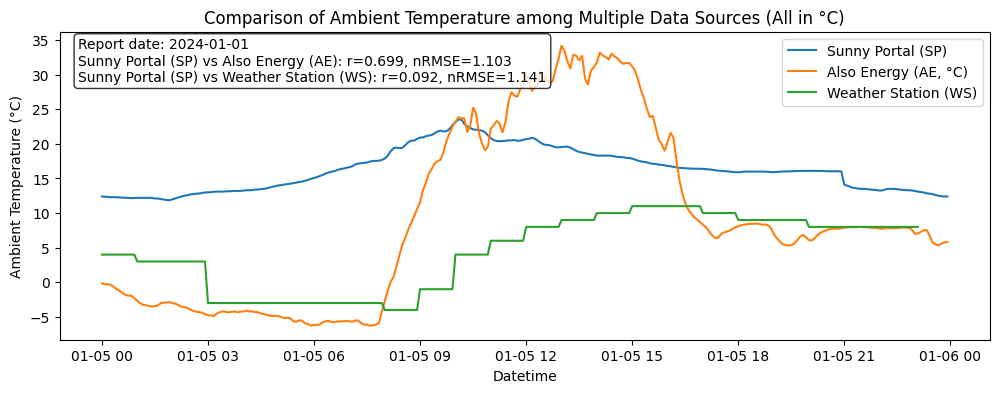

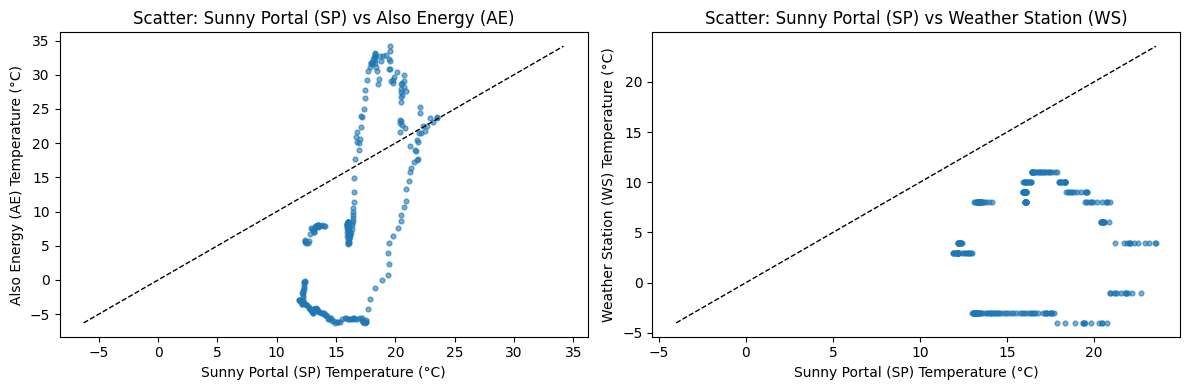

In [100]:
# Case 1: Ambient Temperature comparison (SP vs AE vs WS)
sp_temp = sp_df[["time", "ambient_temp"]].dropna()

ae_temp = resample_to_5min(ae_df, "ambient_temp", method="mean")
# Convert AE temp from Fahrenheit to Celsius
ae_temp["ambient_temp"] = (ae_temp["ambient_temp"] - 32) * 5.0 / 9.0

ws_temp = resample_to_5min(ws_df, "ambient_temperature", method="ffill")
# Assume WS is already in Celsius according to your prompt.

sp_ae = align_on_time(sp_temp, "ambient_temp", ae_temp, "ambient_temp")
sp_ws = align_on_time(sp_temp, "ambient_temp", ws_temp, "ambient_temperature")

r_sp_ae = pearson_corr(sp_ae["ambient_temp"], sp_ae["ambient_temp_other"])
nrmse_sp_ae = nrmse(sp_ae["ambient_temp"], sp_ae["ambient_temp_other"])

r_sp_ws = pearson_corr(sp_ws["ambient_temp"], sp_ws["ambient_temperature"])
nrmse_sp_ws = nrmse(sp_ws["ambient_temp"], sp_ws["ambient_temperature"])

fig, ax = plt.subplots(figsize=(12, 4))
ax.plot(sp_temp["time"], sp_temp["ambient_temp"], label="Sunny Portal (SP)")
ax.plot(sp_ae["time"], sp_ae["ambient_temp_other"], label="Also Energy (AE, °C)")
ax.plot(sp_ws["time"], sp_ws["ambient_temperature"], label="Weather Station (WS)")
ax.set_title("Comparison of Ambient Temperature among Multiple Data Sources (All in °C)")
ax.set_xlabel("Datetime")
ax.set_ylabel("Ambient Temperature (°C)")
ax.legend()
add_text_box(
    ax,
    "Report date: 2024-01-01\n"
    f"Sunny Portal (SP) vs Also Energy (AE): r={r_sp_ae:.3f}, nRMSE={nrmse_sp_ae:.3f}\n"
    f"Sunny Portal (SP) vs Weather Station (WS): r={r_sp_ws:.3f}, nRMSE={nrmse_sp_ws:.3f}",
)
plt.show()

fig, axes = plt.subplots(1, 2, figsize=(12, 4))
plot_scatter(
    axes[0],
    sp_ae["ambient_temp"],
    sp_ae["ambient_temp_other"],
    "Scatter: Sunny Portal (SP) vs Also Energy (AE)",
    "Sunny Portal (SP) Temperature (°C)",
    "Also Energy (AE) Temperature (°C)",
)
plot_scatter(
    axes[1],
    sp_ws["ambient_temp"],
    sp_ws["ambient_temperature"],
    "Scatter: Sunny Portal (SP) vs Weather Station (WS)",
    "Sunny Portal (SP) Temperature (°C)",
    "Weather Station (WS) Temperature (°C)",
)
plt.tight_layout()
plt.show()


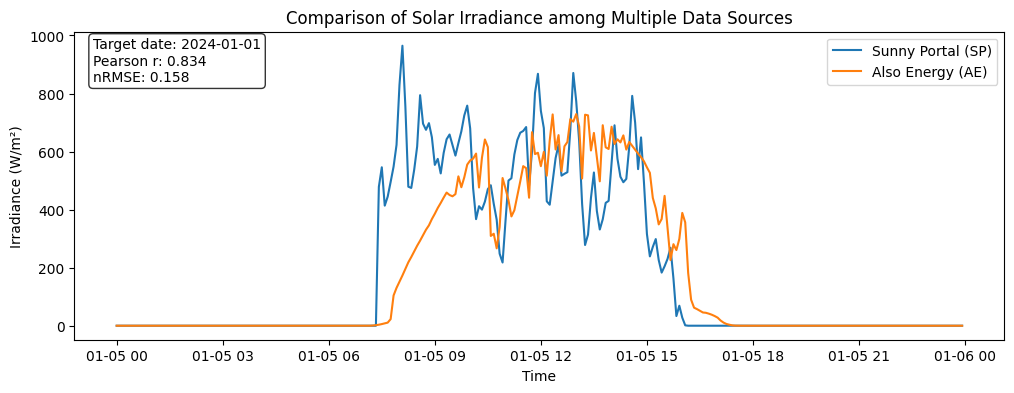

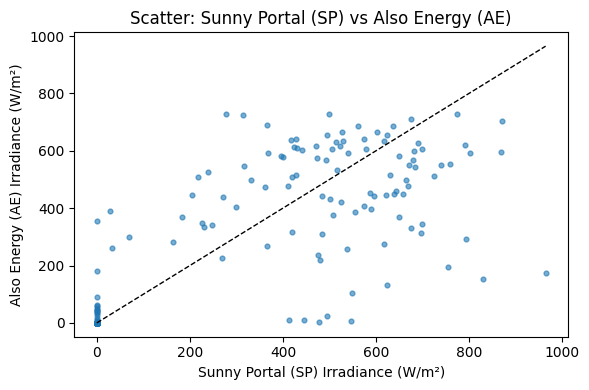

In [101]:
# Case 2: Solar irradiance comparison (SP vs AE)
sp_ir = sp_df[["time", "ir"]].dropna()
ae_ghi = resample_to_5min(ae_df, "ghi", method="mean")

sp_ae_ghi = align_on_time(sp_ir, "ir", ae_ghi, "ghi")

r_sp_ae_ghi = pearson_corr(sp_ae_ghi["ir"], sp_ae_ghi["ghi"])
nrmse_sp_ae_ghi = nrmse(sp_ae_ghi["ir"], sp_ae_ghi["ghi"])

fig, ax = plt.subplots(figsize=(12, 4))
ax.plot(sp_ae_ghi["time"], sp_ae_ghi["ir"], label="Sunny Portal (SP)")
ax.plot(sp_ae_ghi["time"], sp_ae_ghi["ghi"], label="Also Energy (AE)")
ax.set_title("Comparison of Solar Irradiance among Multiple Data Sources")
ax.set_xlabel("Time")
ax.set_ylabel("Irradiance (W/m²)")
ax.legend()
add_text_box(
    ax,
    "Target date: 2024-01-01\n"
    f"Pearson r: {r_sp_ae_ghi:.3f}\n"
    f"nRMSE: {nrmse_sp_ae_ghi:.3f}",
)
plt.show()

fig, ax = plt.subplots(figsize=(6, 4))
plot_scatter(
    ax,
    sp_ae_ghi["ir"],
    sp_ae_ghi["ghi"],
    "Scatter: Sunny Portal (SP) vs Also Energy (AE)",
    "Sunny Portal (SP) Irradiance (W/m²)",
    "Also Energy (AE) Irradiance (W/m²)",
)
plt.tight_layout()
plt.show()


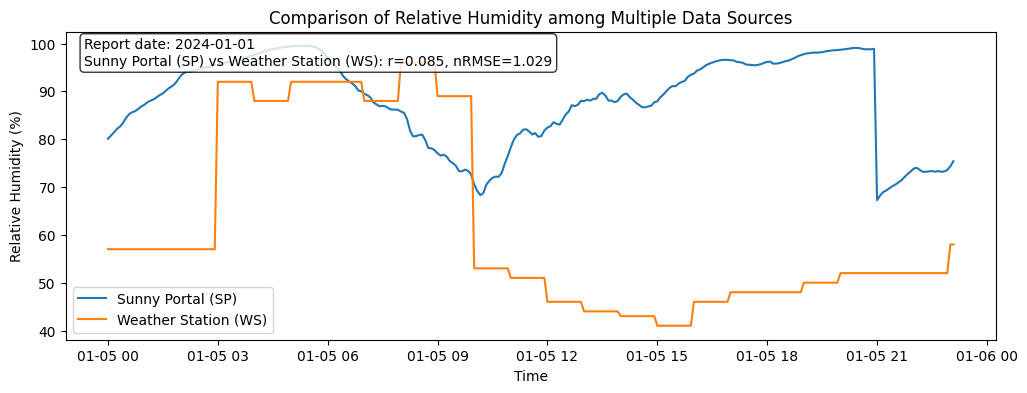

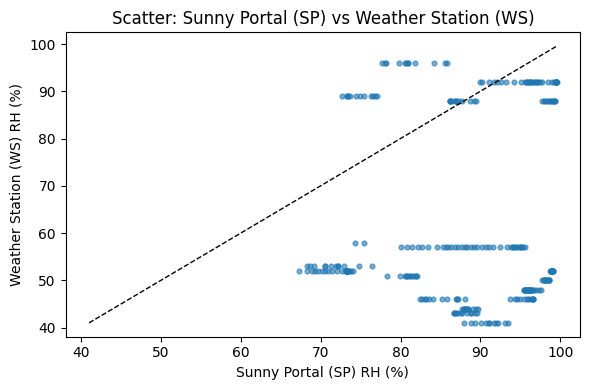

In [102]:
# Case 3: Relative humidity comparison (SP vs WS)
sp_rh = sp_df[["time", "ambient_rh"]].dropna()
ws_rh = resample_to_5min(ws_df, "relative_humidity", method="ffill")

sp_ws_rh = align_on_time(sp_rh, "ambient_rh", ws_rh, "relative_humidity")

r_sp_ws_rh = pearson_corr(sp_ws_rh["ambient_rh"], sp_ws_rh["relative_humidity"])
nrmse_sp_ws_rh = nrmse(sp_ws_rh["ambient_rh"], sp_ws_rh["relative_humidity"])

fig, ax = plt.subplots(figsize=(12, 4))
ax.plot(sp_ws_rh["time"], sp_ws_rh["ambient_rh"], label="Sunny Portal (SP)")
ax.plot(sp_ws_rh["time"], sp_ws_rh["relative_humidity"], label="Weather Station (WS)")
ax.set_title("Comparison of Relative Humidity among Multiple Data Sources")
ax.set_xlabel("Time")
ax.set_ylabel("Relative Humidity (%)")
ax.legend()
add_text_box(
    ax,
    "Report date: 2024-01-01\n"
    f"Sunny Portal (SP) vs Weather Station (WS): r={r_sp_ws_rh:.3f}, nRMSE={nrmse_sp_ws_rh:.3f}",
)
plt.show()

fig, ax = plt.subplots(figsize=(6, 4))
plot_scatter(
    ax,
    sp_ws_rh["ambient_rh"],
    sp_ws_rh["relative_humidity"],
    "Scatter: Sunny Portal (SP) vs Weather Station (WS)",
    "Sunny Portal (SP) RH (%)",
    "Weather Station (WS) RH (%)",
)
plt.tight_layout()
plt.show()


User config: N_ser_A=18, N_ser_B=18 | Vdc scale A/B: 1/1


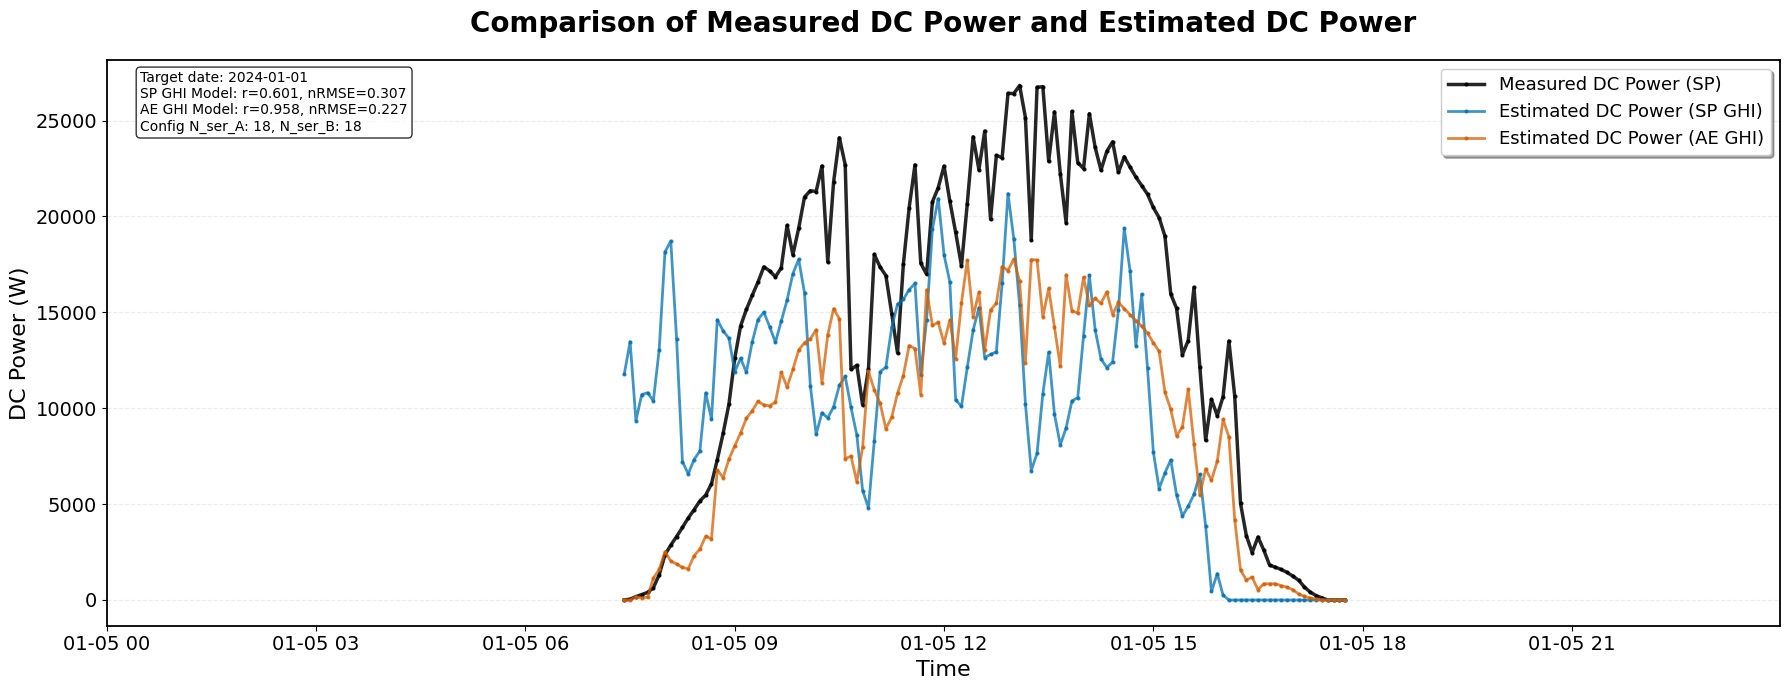

TypeError: matplotlib.axes._axes.Axes.scatter() got multiple values for keyword argument 's'

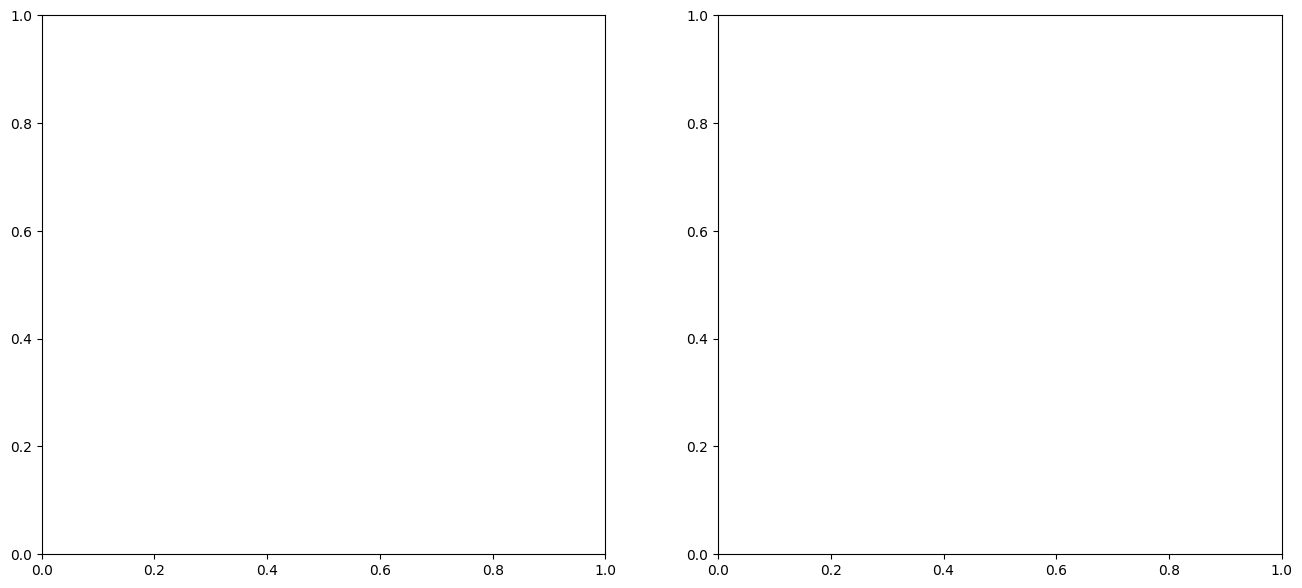

In [104]:
# DC Power estimation using specified array and module parameters
# (parameters and formulas as in Data_management.ipynb context above)

# PV array configuration
N_par = 2            # Parallel strings
N_ser_A = 18         # Series modules per string, channel A
N_ser_B = 18         # Series modules per string, channel B

# Module parameters (Canadian Solar CS6U-330P / User-defined)
N_cell = 72           # Cells per module
Voc_ref = 45.6        # Open circuit voltage (V)
Isc_ref = 9.45        # Short-circuit current (A)
Vmp_ref = 37.2        # Voltage at max power (V)
Imp_ref = 8.88        # Current at max power (A)
alpha_Isc_pct = 0.053 # %/deg.C
beta_Voc_pct = -0.31  # %/deg.C

# Model parameters
IL_ref = 9.4605           # Light-generated current (A)
I0_ref = 4.8779e-11       # Diode saturation current (A)
n_diode = 0.94901         # Diode ideality factor
Rsh_ref = 311.8211        # Shunt resistance (Ohms)
Rs_ref = 0.34751          # Series resistance (Ohms)

# Constants
q = 1.60217646e-19
k = 1.38064852e-23
Eg = 1.121
T_ref_C = 25
T_ref_K = T_ref_C + 273.15
G_ref = 1000

# --------------- DC Current Calculation via Single-Diode Model ---------------
def estimate_dc_current_at_voltage(irradiance, temp_c, vdc, n_ser):
    """Estimate array DC current at given string voltage and array conditions."""
    if (
        irradiance is None
        or temp_c is None
        or vdc is None
        or np.isnan(irradiance)
        or np.isnan(temp_c)
        or np.isnan(vdc)
        or irradiance <= 0
        or vdc < 0
    ):
        return 0.0

    T_K = temp_c + 273.15
    dT = T_K - T_ref_K
    alpha_Isc = (alpha_Isc_pct / 100.0) * Isc_ref

    # Photo-current - adjusted for temp and irradiance
    IL = (IL_ref + alpha_Isc * dT) * (irradiance / G_ref)

    # Saturation current - temp dependence
    exponent = (q * Eg) / (n_diode * k) * ((1 / T_ref_K) - (1 / T_K))
    I0 = I0_ref * (T_K / T_ref_K) ** 3 * np.exp(exponent)

    # Thermal voltage scaling
    Vt_ref = (N_cell * k * T_ref_K) / q * n_diode
    Vt = Vt_ref * (T_K / T_ref_K)

    # Resistances
    Rs = Rs_ref
    Rsh = Rsh_ref * (G_ref / irradiance) if irradiance > 0 else Rsh_ref

    # Scale to array level
    Rs_array = Rs * (n_ser / N_par)
    Rsh_array = Rsh * (n_ser / N_par)
    IL_array = IL * N_par
    I0_array = I0 * N_par
    Vt_array = Vt * n_ser

    # Solve for I_dc using Newton-Raphson (similar to notebook context)
    I = IL_array
    for _ in range(30):
        exp_arg = (vdc + I * Rs_array) / Vt_array
        exp_term = np.exp(np.clip(exp_arg, -50, 50))
        f = (
            I
            - IL_array
            + I0_array * (exp_term - 1)
            + (vdc + I * Rs_array) / Rsh_array
        )
        df = (
            1
            + I0_array * exp_term * (Rs_array / Vt_array)
            + (Rs_array / Rsh_array)
        )
        I_new = I - f / df
        if I_new < 0:
            I_new = 0
        if abs(I_new - I) < 1e-6:
            I = I_new
            break
        I = I_new

    return float(I)

# --------------- Data preparation and DC Power calculation ---------------

# Extract relevant columns and treat -1 as NaN for missing
sp_power = sp_df[[
    "time", "dc_power_a", "dc_power_b",
    "dc_voltage_a", "dc_voltage_b",
    "ir", "ambient_temp"
]].copy()
sp_power = sp_power.replace(-1, np.nan)
sp_power = sp_power.dropna(subset=[
    "dc_voltage_a", "dc_voltage_b", "ir", "ambient_temp"
])
sp_power = sp_power[(sp_power["dc_voltage_a"] > 0) & (sp_power["dc_voltage_b"] > 0)]
sp_power["dc_power"] = sp_power["dc_power_a"] + sp_power["dc_power_b"]

# AE GHI aligned to spacepower timestamps
ae_ghi_5min = resample_to_5min(ae_df, "ghi", method="mean")
ae_ghi_aligned = align_on_time(sp_power[["time", "ir"]], "ir", ae_ghi_5min, "ghi")
sp_power = sp_power.merge(ae_ghi_aligned[["time", "ghi"]], on="time", how="left")
sp_power = sp_power.dropna(subset=["ghi"])

# Prepare arrays and scaled voltages for both channels
vdc_a = sp_power["dc_voltage_a"].values
vdc_b = sp_power["dc_voltage_b"].values
ghi_sp = sp_power["ir"].values
ghi_ae = sp_power["ghi"].values
temp_c = sp_power["ambient_temp"].values

# Reference open-circuit string voltage at 25C per channel
voc_str_a = Voc_ref * N_ser_A
voc_str_b = Voc_ref * N_ser_B

# Scaling the measured Vdc to remove excess parallelism and reflect the string count
vdc_scale_a = max(1, int(round(np.median(vdc_a) / voc_str_a)))
vdc_scale_b = max(1, int(round(np.median(vdc_b) / voc_str_b)))
vdc_model_a = vdc_a / vdc_scale_a
vdc_model_b = vdc_b / vdc_scale_b

print(
    f"User config: N_ser_A={N_ser_A}, N_ser_B={N_ser_B} | Vdc scale A/B: {vdc_scale_a}/{vdc_scale_b}"
)

# Estimate DC power using SP IR and AE GHI for each channel
sp_power["i_est_spghi_a"] = [
    estimate_dc_current_at_voltage(g, t, v, N_ser_A)
    for g, t, v in zip(ghi_sp, temp_c, vdc_model_a)
]
sp_power["i_est_spghi_b"] = [
    estimate_dc_current_at_voltage(g, t, v, N_ser_B)
    for g, t, v in zip(ghi_sp, temp_c, vdc_model_b)
]
sp_power["p_est_spghi_a"] = sp_power["i_est_spghi_a"] * sp_power["dc_voltage_a"]
sp_power["p_est_spghi_b"] = sp_power["i_est_spghi_b"] * sp_power["dc_voltage_b"]
sp_power["p_est_spghi"] = sp_power["p_est_spghi_a"] + sp_power["p_est_spghi_b"]

sp_power["i_est_aeghi_a"] = [
    estimate_dc_current_at_voltage(g, t, v, N_ser_A)
    for g, t, v in zip(ghi_ae, temp_c, vdc_model_a)
]
sp_power["i_est_aeghi_b"] = [
    estimate_dc_current_at_voltage(g, t, v, N_ser_B)
    for g, t, v in zip(ghi_ae, temp_c, vdc_model_b)
]
sp_power["p_est_aeghi_a"] = sp_power["i_est_aeghi_a"] * sp_power["dc_voltage_a"]
sp_power["p_est_aeghi_b"] = sp_power["i_est_aeghi_b"] * sp_power["dc_voltage_b"]
sp_power["p_est_aeghi"] = sp_power["p_est_aeghi_a"] + sp_power["p_est_aeghi_b"]

# --------------- Correlation and plotting ---------------

r_sp_est = pearson_corr(sp_power["dc_power"], sp_power["p_est_spghi"])
nrmse_sp_est = nrmse(sp_power["dc_power"], sp_power["p_est_spghi"])

r_ae_est = pearson_corr(sp_power["dc_power"], sp_power["p_est_aeghi"])
nrmse_ae_est = nrmse(sp_power["dc_power"], sp_power["p_est_aeghi"])

# --- Plot comparison time series (larger, more visible style) ---
fig, ax = plt.subplots(figsize=(18, 7))  # Larger figure
ax.plot(
    sp_power["time"], sp_power["dc_power"],
    label="Measured DC Power (SP)", color='black', lw=2.5, marker='o', markersize=2, alpha=0.85
)
ax.plot(
    sp_power["time"], sp_power["p_est_spghi"],
    label="Estimated DC Power (SP GHI)", color='#0072B2', lw=2, marker='o', markersize=2, alpha=0.75
)
ax.plot(
    sp_power["time"], sp_power["p_est_aeghi"],
    label="Estimated DC Power (AE GHI)", color='#D55E00', lw=2, marker='o', markersize=2, alpha=0.75
)
ax.set_title(
    "Comparison of Measured DC Power and Estimated DC Power",
    fontsize=20, fontweight='bold', pad=20
)
ax.set_xlabel("Time", fontsize=16)
ax.set_ylabel("DC Power (W)", fontsize=16)
ax.set_xlim(
    target_date.replace(hour=0, minute=0, second=0),
    target_date.replace(hour=23, minute=59, second=0),
)
ax.tick_params(axis='both', labelsize=14)
ax.legend(fontsize=13, loc='best', frameon=True, shadow=True)
# Remove unsupported fontsize argument and facecolor from add_text_box call:
add_text_box(
    ax,
    "Target date: 2024-01-01\n"
    f"SP GHI Model: r={r_sp_est:.3f}, nRMSE={nrmse_sp_est:.3f}\n"
    f"AE GHI Model: r={r_ae_est:.3f}, nRMSE={nrmse_ae_est:.3f}\n"
    f"Config N_ser_A: {N_ser_A}, N_ser_B: {N_ser_B}"
)
for spine in ax.spines.values():
    spine.set_linewidth(1.3)
plt.tight_layout()
plt.grid(True, which='both', axis='y', ls='--', alpha=0.25)
plt.show()

# --- Plot measured vs estimated (SP GHI and AE GHI) - LARGER AND THICKER ---
fig, axes = plt.subplots(1, 2, figsize=(16, 7))
plot_scatter(
    axes[0],
    sp_power["dc_power"],
    sp_power["p_est_spghi"],
    "Measured vs Estimated DC Power (SP GHI)",
    "Measured DC Power (W)",
    "Estimated DC Power (W)",
    marker='o',
    s=16,
    alpha=0.65,
    color="#0072B2"
)
axes[0].tick_params(axis='both', labelsize=14)
axes[0].set_title("Measured vs Estimated DC Power (SP GHI)", fontsize=16, fontweight='bold')
axes[0].set_xlabel("Measured DC Power (W)", fontsize=15)
axes[0].set_ylabel("Estimated DC Power (W)", fontsize=15)
axes[0].grid(True, which='both', axis='both', ls='--', alpha=0.25)

plot_scatter(
    axes[1],
    sp_power["dc_power"],
    sp_power["p_est_aeghi"],
    "Measured vs Estimated DC Power (AE GHI)",
    "Measured DC Power (W)",
    "Estimated DC Power (W)",
    marker='o',
    s=16,
    alpha=0.65,
    color="#D55E00"
)
axes[1].tick_params(axis='both', labelsize=14)
axes[1].set_title("Measured vs Estimated DC Power (AE GHI)", fontsize=16, fontweight='bold')
axes[1].set_xlabel("Measured DC Power (W)", fontsize=15)
axes[1].set_ylabel("Estimated DC Power (W)", fontsize=15)
axes[1].grid(True, which='both', axis='both', ls='--', alpha=0.25)

plt.tight_layout()
plt.show()


In [110]:
de_df.columns
#sp_df.columns

Index(['time', 'current_ng_rms_rms', 'current_ng_rms', 'current_an_rms_rms',
       'current_an_rms', 'current_line_to_neutral_average_rms',
       'current_bn_rms', 'current_cn_rms', 'current_an_totalthd',
       'current_bn_totalthd', 'current_cn_totalthd', 'power_total_s',
       'power_total_q', 'power_total_p', 'voltage_an_totalthd',
       'voltage_bn_totalthd', 'voltage_cn_totalthd', 'voltage_an_flkrplt',
       'voltage_bn_flkrplt', 'voltage_bn_flkrpst', 'voltage_cn_flkrplt',
       'voltage_cn_flkrpst', 'voltage_an_flkrpst', 'voltage_an_rms',
       'voltage_bn_rms', 'voltage_cn_rms',
       'voltage_line_to_neutral_average_rms'],
      dtype='object')

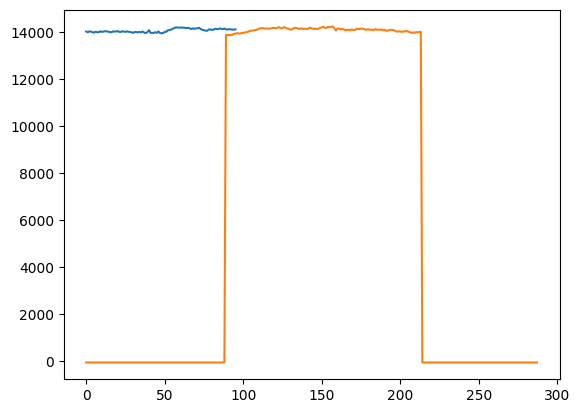

In [113]:
plt.plot(de_df['voltage_an_rms'].values) # Miss MAX MIN
plt.plot(sp_df['ac_voltage_l1'].values * 49.578) # Consider the time difference
#plt.plot(de_df['voltage_cn_rms'].values)
